
## Post-processing of TRANSPIRE results
***


In [1]:
import TRANSPIRE

import pandas as pd
import numpy as np

### 1. Load data, define comparisons, and generate synthetic translocations

In [2]:
f = 'mydata.csv'
df = TRANSPIRE.data.import_data.load_data(f)

comparisons = [('uninfected', 'infected')]

synthetic_translocations = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons)
mapping, mapping_r = TRANSPIRE.utils.get_mapping(df)

synthetic_translocations.head()

1   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.121081   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.121081   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   

                                                                                                                                                          2   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.378059   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.378059   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   

                                                                                                                                                          3   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.287889   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.287889   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   

                                                                                                                                                          4   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.142575   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.142575   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.1

### 2. Load TRANSPIRE predictions

In [3]:
predictions = TRANSPIRE.data.import_data.load_predictions('results.csv')

### 3. Perform GO enrichment analysis on translocating protiens

**Make GOAnalyzer to perform enrichment analyses (facilitated by GOATOOLS)**

In [4]:
# define a background set of genes to assess enrichment against
background = df.index.get_level_values('accession').unique()
GO_analyzer = TRANSPIRE.go_enrichment.GOAnalyzer(background, species = '9606', alpha = 0.05, method = 'fdr_bh')

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-05-02) 47,240 GO Terms
HMS:0:00:03.614330 336,356 annotations, 20,586 genes, 18,410 GOs, 1 taxids READ: gene2go 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 95%  3,051 of  3,196 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 98%  3,147 of  3,196 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 95%  3,032 of  3,196 population items found in association


**Perform GO enrichment analysis for translocating proteins**

In [20]:
translocation_accs = predictions.index.get_level_values('accession_A')[predictions['passes cutoff?']].unique()
translocation_enrichment = GO_analyzer.get_enrichment(translocation_accs)


Run BP Gene Ontology Analysis: current study set of 728 IDs ...
 96%    701 of    727 study items found in association
100%    727 of    728 study items found in population(3196)
Calculating 6,820 uncorrected p-values using fisher_scipy_stats
   6,820 GO terms are associated with  3,049 of  3,196 population items
   3,239 GO terms are associated with    701 of    727 study items
  METHOD fdr_bh:
      30 GO terms found significant (< 0.05=alpha) ( 26 enriched +   4 purified): statsmodels fdr_bh
     260 study items associated with significant GO IDs (enriched)
       4 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 728 IDs ...
 99%    722 of    727 study items found in association
100%    727 of    728 study items found in population(3196)
Calculating 1,109 uncorrected p-values using fisher_scipy_stats
   1,109 GO terms are associated with  3,145 of  3,196 population items
     622 GO terms are associated with    722 of  

In [21]:
translocation_enrichment

,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
GO accession,,,,,,,,,,
GO:0006413,BP,e,translational initiation,67/727,103/3196,1.138456e-20,3,67,7.764267e-17,"1654, 1964, 1965, 1968, 1973, 1981, 1982, 3646..."
GO:0000184,BP,e,"nuclear-transcribed mRNA catabolic process, no...",53/727,83/3196,5.171506e-16,10,53,1.763483e-12,"1981, 2935, 3646, 3921, 5515, 5976, 6122, 6124..."
GO:0006614,BP,e,SRP-dependent cotranslational protein targetin...,50/727,81/3196,2.685849e-14,12,50,6.105829e-11,"3921, 6122, 6124, 6125, 6133, 6134, 6135, 6137..."
GO:0019083,BP,e,viral transcription,48/727,77/3196,5.258122e-14,4,48,8.965097e-11,"3921, 6122, 6124, 6125, 6133, 6134, 6135, 6137..."
GO:0006886,BP,e,intracellular protein transport,65/727,131/3196,6.139768e-12,8,65,8.374644e-09,"160, 161, 162, 163, 164, 372, 378, 381, 400, 1..."
GO:0006890,BP,e,"retrograde vesicle-mediated transport, Golgi t...",28/727,39/3196,7.885321e-11,6,28,8.962982e-08,"372, 378, 381, 1314, 1315, 3831, 5861, 6836, 6..."
GO:0006888,BP,e,endoplasmic reticulum to Golgi vesicle-mediate...,42/727,87/3196,1.485486e-07,6,42,1.447288e-04,"372, 378, 1314, 1315, 1639, 1778, 1781, 2621, ..."
GO:0006412,BP,e,translation,57/727,134/3196,2.370902e-07,7,57,2.021194e-04,"207, 1615, 1915, 1981, 2935, 3921, 5610, 6122,..."
GO:0043488,BP,e,regulation of mRNA stability,31/727,60/3196,9.324625e-07,9,31,6.359395e-04,"207, 1981, 3315, 3842, 5578, 5684, 5689, 5700,..."


**Plot the enriched terms and their values**

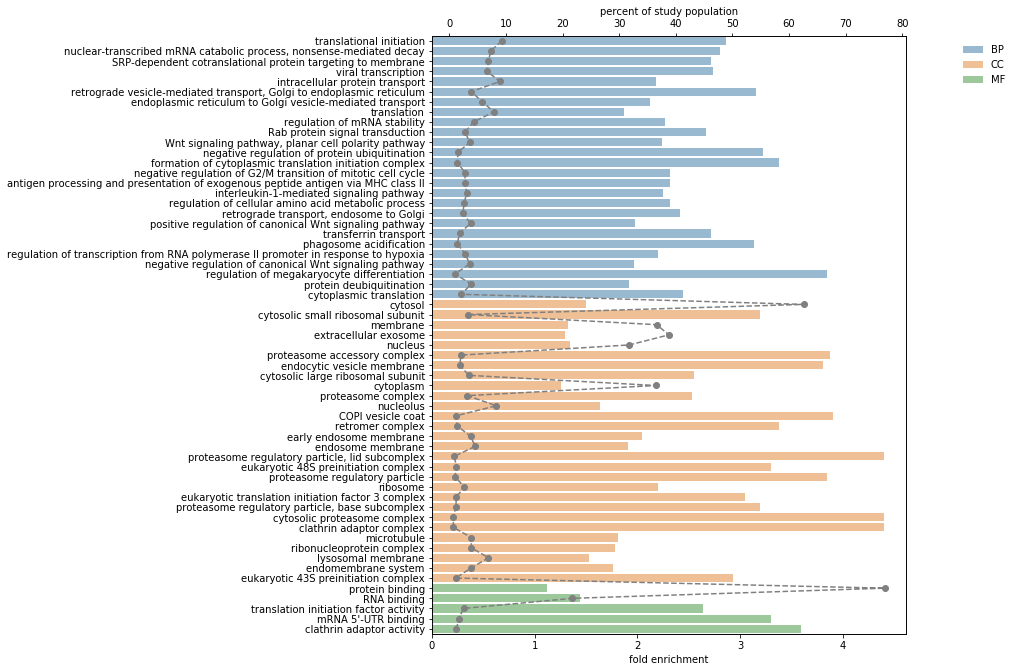

In [27]:
import matplotlib.pyplot as plt

TRANSPIRE.visualization.result_visualization.plot_GO_enrichment_results(translocation_enrichment, orient='horizontal')
plt.show()

### 4. Determine co-translocating proteins
**Compute Mahalanobis distances between all proteins**

In [5]:
possible_translocation_profiles =TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons, synthetic=False).reset_index().set_index(predictions.index.names)

# get rid of index levels that aren't informative
possible_translocation_profiles = possible_translocation_profiles.reset_index(['localization_A', 'localization_B', 'accession_B', 'gene name_B'], drop=True)

possible_translocation_profiles.index.names = ['condition_A', 'condition_B', 'accession', 'gene name']
dists = possible_translocation_profiles.groupby(['condition_A', 'condition_B']).apply(lambda x: TRANSPIRE.cotranslocation.compute_distance(x.loc[x.name, :]))
dists = dists.reset_index().melt(dists.index.names).dropna().set_index(['condition_A', 'condition_B', 'accession_A', 'accession_B', 'gene name_A', 'gene name_B']).squeeze()

In [20]:
dists.sort_values()

condition_A  condition_B  accession_A  accession_B  gene name_A  gene name_B
uninfected   infected     P13667       Q15084       PDIA4        PDIA6            0.487088
                          P51398       Q5JTZ9       DAP3         AARS2            0.521965
                          P04083       P08758       ANXA1        ANXA5            0.546352
                          P30040       P30101       ERP29        PDIA3            0.548835
                          P34897       Q99797       SHMT2        MIPEP            0.641325
                                                                                   ...    
                          P35527       Q6P1Q0       KRT9         LETMD1         111.279417
                                       Q9NSI6       KRT9         BRWD1          111.435963
                                       Q9NYJ1       KRT9         COA4           111.567667
                                       Q8TAA5       KRT9         GRPEL2         112.014439
             

**Load CORUM complexes**

In [21]:
corum, prot_to_complex, complex_to_prot = TRANSPIRE.data.import_data.load_CORUM()

**Extract true postive (members of CORUM complexes) and true negative (marker proteins of distinct subcellular organelles) populations from the data**

In [62]:
tn = TRANSPIRE.cotranslocation.extract_true_neg(dists, df)
tp = TRANSPIRE.cotranslocation.extract_true_pos(dists, complex_to_prot, prot_to_complex)

**Compute a false-positive rate based on true negative and true positive populations**

In [67]:
fpr = TRANSPIRE.cotranslocation.compute_fpr(tp, tn)

**Determine a distance cutoff based on your desired fpr**

In [92]:
fpr_cutoff = 0.05 # 5% FPR cutoff
dist_cutoff = fpr.groupby(['condition_A', 'condition_B']).apply(lambda x: x[x<=fpr_cutoff].idxmax()[0])

**Identify cotranslocation based on distance cutoff**

In [99]:
transloc_accs = predictions.index.get_level_values('accession_A')[predictions['passes cutoff?']].unique()
transloc_dists = dists[dists.index.get_level_values('accession_A').isin(transloc_accs)&dists.index.get_level_values('accession_B').isin(transloc_accs)]

cotransloc_dists = transloc_dists[transloc_dists <= dist_cutoff.loc[list(zip(transloc_dists.index.get_level_values('condition_A'), transloc_dists.index.get_level_values('condition_B')))].values]
cotransloc_accs = np.unique(cotransloc_dists.index.get_level_values('accession_A').values.tolist()+cotransloc_dists.index.get_level_values('accession_B').values.tolist())

**Query STRINGdb for known interactions**

In [102]:
gsi = TRANSPIRE.cotranslocation.GetSTRINGInteractions()
known_interactions = gsi.query(cotransloc_accs, '9606')

In [103]:
known_interactions.head()

stringId_A       stringId_B preferredName_A  \
Accession_A Accession_B                                                     
Q16401      P43686       ENSP00000210313  ENSP00000157812           PSMD5   
P48556      P43686       ENSP00000215071  ENSP00000157812           PSMD8   
            Q16401       ENSP00000215071  ENSP00000210313           PSMD8   
Q9Y5K8      O94804       ENSP00000216442  ENSP00000176763         ATP6V1D   
P25788      P43686       ENSP00000216455  ENSP00000157812           PSMA3   

                        preferredName_B  ncbiTaxonId  score  nscore  fscore  \
Accession_A Accession_B                                                       
Q16401      P43686                PSMC4         9606  0.989   0.000     0.0   
P48556      P43686                PSMC4         9606  0.999   0.000     0.0   
            Q16401                PSMD5         9606  0.990   0.000     0.0   
Q9Y5K8      O94804                STK10         9606  0.900   0.000     0.0   
P25788      P43686                PSMC4         9606  0.999   0.059     0.0   

                         pscore  ascore  escore  dscore  tscore  
Accession_A Accession_B                                          
Q16401      P43686        0.000   0.063   0.827     0.9   0.410  
P48556      P43686        0.000   0.880   0.994     0.9   0.917  
            Q16401        0.000   0.081   0.869     0.9   0.290  
Q9Y5K8      O94804        0.000   0.000   0.000     0.9   0.000  
P25788      P43686        0.201   0.798   0.994     0.9   0.429

**Combine known interaction information with cotranslocation information**

In [110]:
isknown = pd.Series(cotransloc_dists.reset_index([n for n in cotransloc_dists.index.names if not 'accession' in n]).index.isin(known_interactions.index), index = cotransloc_dists.index)

pd.concat([cotransloc_dists, isknown], axis=1, keys = ['Mahalanobis distance', 'known interaction?'])

Mahalanobis distance  \
condition_A condition_B accession_A accession_B gene name_A gene name_B                         
uninfected  infected    A0AVT1      O00231      UBA6        PSMD11                   2.482505   
                        O00154      O00231      ACOT7       PSMD11                   3.157640   
                        O00203      O00231      AP3B1       PSMD11                   3.091579   
                        O00231      O00232      PSMD11      PSMD12                   2.637260   
                        A0AVT1      O00425      UBA6        IGF2BP3                  2.502198   
...                                                                                       ...   
                        Q9UNM6      Q9Y6M1      PSMD13      IGF2BP2                  2.395706   
                        Q9Y230      Q9Y6M1      RUVBL2      IGF2BP2                  2.972433   
                        Q9Y265      Q9Y6M1      RUVBL1      IGF2BP2                  3.339705   
                        Q9Y3I0      Q9Y6M1      RTCB        IGF2BP2                  2.039269   
                        Q9Y678      Q9Y6M1      COPG1       IGF2BP2                  2.863510   

                                                                         known interaction?  
condition_A condition_B accession_A accession_B gene name_A gene name_B                      
uninfected  infected    A0AVT1      O00231      UBA6        PSMD11                     True  
                        O00154      O00231      ACOT7       PSMD11                    False  
                        O00203      O00231      AP3B1       PSMD11                    False  
                        O00231      O00232      PSMD11      PSMD12                     True  
                        A0AVT1      O00425      UBA6        IGF2BP3                   False  
...                                                                                     ...  
                        Q9UNM6      Q9Y6M1      PSMD13      IGF2BP2                   False  
                        Q9Y230      Q9Y6M1      RUVBL2      IGF2BP2                   False  
                        Q9Y265      Q9Y6M1      RUVBL1      IGF2BP2                   False  
                        Q9Y3I0      Q9Y6M1      RTCB        IGF2BP2                   False  
                        Q9Y678      Q9Y6M1      COPG1       IGF2BP2                   False  

[15265 rows x 2 columns]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>